In [95]:
import os
from os import makedirs

dataset_path = os.environ["DATA"] + "/00_datasets/DFT/QM9/QM9_smi_datasets/train_test_dataset_100000.smi"
json_cache_location = os.environ["DATA"] + "/00_datasets/DFT/QM9/cache_QM9.json"

output_results_path = os.environ["DATA"] + "/07_BBO/02_models/v3/01.01_GPR_HOMO_QM9_constantkernel_hyperoptim/"
output_figures_path = os.environ["FIGURES"] + "/07_BBO/02_models/v3/01.01_GPR_HOMO_QM9_constantkernel_hyperoptim/"

dft_path = os.environ["DFT_COMPUT_OBABEL_MM"]
    
N_MOL = 3000

CV_INTERNAL = 5
CV_EXTERNAL = 10

N_JOBS=55

ALPHAS = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]

MM_program = "obabel"


makedirs(output_figures_path, exist_ok=True)

In [96]:
from bbo.objective import EvoMolEvaluationStrategyWrapper
from evomol.evomol.evaluation_dft import OPTEvaluationStrategy

objective = EvoMolEvaluationStrategyWrapper(
    OPTEvaluationStrategy("homo", n_jobs=2, cache_files=[json_cache_location], 
                          working_dir_path=dft_path,
                          MM_program=MM_program))

133798 molecules in cache


In [97]:
from os import makedirs

makedirs(output_results_path, exist_ok=True)

In [98]:
import numpy as np
from sklearn.gaussian_process.kernels import StationaryKernelMixin, NormalizedKernelMixin, Kernel

class SOAPKernelVectorized(StationaryKernelMixin, NormalizedKernelMixin, Kernel):
    
    def __init__(self, xi=2):
        self.xi = xi
        
    def __call__(self, X, Y=None, eval_gradient=False):
        
        if Y is None:
            Y = X
            
        # Extracting the dimensions of both matrices
        X_dim = X.shape[0]
        Y_dim = Y.shape[0]

        # Computing the dot product of each matrix with itself and with the other
        dot_X_X = X.dot(X.T)
        dot_X_Y = X.dot(Y.T)
        dot_Y_Y = Y.dot(Y.T)

        # Extracting the dot product of each element of each matrix with itself
        diag_X = np.diag(dot_X_X)
        diag_Y = np.diag(dot_Y_Y)

        # Building the matrix of dimension (X_dim, Y_dim) containing in each line the dot product of the nth
        # element of X with itself
        X_dot_matrix = np.tile(diag_X, Y_dim).reshape((Y_dim, X_dim)).T

        # Building the matrix of dimension (X_dim, Y_dim) containing in each column the dot product of the nth
        # element of Y with itself
        Y_dot_matrix = np.tile(diag_Y, X_dim).reshape((X_dim, Y_dim))

        # Computing the SOAP kernel of X and Y
        K = (dot_X_Y/np.sqrt(X_dot_matrix * Y_dot_matrix))**self.xi
        
        if np.sum(np.isinf(K)) > 0:
            print("Inf values in kernel")
            
        if np.sum(np.isnan(K)) > 0:
            print("Nan values in kernel")
        
        # Replacing possible nan values due to zero by zero division
        K[np.isnan(K)] = 0
        
        if eval_gradient:
            return K, np.empty((X.shape[0], X.shape[0], 0))
        else:
            return K
    

    def get_params(self, deep=True):
        return {"xi": self.xi}
    
    def __repr__(self):
        return "{0}(xi={1:.3g})".format(self.__class__.__name__, self.xi)


In [99]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern, RationalQuadratic, DotProduct


kernels = [("1.0*RBF( 1.0)", 1.0*RBF(1.0)),
           ("1.0*DotProduct( sigma_0=1)", 1.0*DotProduct(sigma_0=1)),
           ("1.0*SOAP( xi=2)", 1.0*SOAPKernelVectorized(xi=2))]


models = []
for kernel in kernels:
    models.append((kernel[0], GaussianProcessRegressor(kernel=kernel[1],
                                                       optimizer="fmin_l_bfgs_b")))


In [100]:
from bbo.descriptor import SOAPDesc, ShinglesVectDesc, MBTRDesc, CoulombMatrixDesc

descriptors_mm = [
    ("SOAP", SOAPDesc(cache_location=None, n_jobs=N_JOBS, average="inner", rcut=4, nmax=5, 
                      lmax=6, species=["C", "H", "O", "N", "F"], MM_program="obabel")),
    ("MBTR", MBTRDesc(cache_location=None, n_jobs=N_JOBS, cosine_angles_n=25, atomic_numbers_n=10, 
                      inverse_distances_n=25, species=["C", "H", "O", "N", "F"], MM_program="obabel")), 
    ("Shingles bool", ShinglesVectDesc(cache_location=None, vect_size=2000)),
    ("Shingles count", ShinglesVectDesc(cache_location=None, count=True, vect_size=2000)),
    ("CM", CoulombMatrixDesc(n_atoms_max=29, cache_location=None, n_jobs=N_JOBS, MM_program="obabel")),
]
    

In [101]:
import json

with open(json_cache_location, "r") as f:
    _cache_dict = json.load(f)

def DFT_cache_geom(smiles, **kwargs):
    return "".join(_cache_dict[smiles]["xyz"]), True

descriptors_qm = [
    ("SOAP", SOAPDesc(cache_location=None, n_jobs=1, average="inner", rcut=4, nmax=5, 
                      lmax=6, species=["C", "H", "O", "N", "F"], MM_program=DFT_cache_geom)),
    ("MBTR", MBTRDesc(cache_location=None, n_jobs=1, cosine_angles_n=25, atomic_numbers_n=10, 
                      inverse_distances_n=25, species=["C", "H", "O", "N", "F"], MM_program=DFT_cache_geom)), 
    ("CM", CoulombMatrixDesc(n_atoms_max=29, cache_location=None, n_jobs=1, MM_program=DFT_cache_geom)),
]
    

In [102]:
from os.path import join
import numpy as np
from sklearn.preprocessing import normalize, scale


def compute_desc_obj(smiles_list, desc_builder, objective):
    
    X, success = desc_builder.transform(smiles_list)
    X = X[success]
    
    smiles_list_filtered = np.array(smiles_list)[success]
    
    y, all_scores, success, comput_times = objective.transform(smiles_list_filtered)
    
    smiles_list_filtered = np.array(smiles_list_filtered)[success]
    
    return X[success], y[success], smiles_list_filtered
    

In [103]:
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from os.path import join
import json

def procedure(models, descriptors, objective, dataset_path, output_path, geometry_type, preprocessing=None):
    
    # Extracting required number of SMILES
    smiles_list = []
    with open(dataset_path, "r") as f:
        for smi in f.readlines()[:N_MOL]:
            smiles_list.append(smi.rstrip())
            
    # Iteration over all descriptors
    for descriptor_tuple in descriptors:
        
        desc_name, desc_builder = descriptor_tuple
                
        # Computing descriptors and objective values for current descriptor 
        X, y, smiles_list_filtered = compute_desc_obj(smiles_list, desc_builder, objective)
        
        # Iteration over all models
        for model_tuple in models:
            
            model_name, model = model_tuple
            
            experiment_name = desc_name + "-" + model_name + "-" + str(preprocessing) + "-" + geometry_type
            experiment_output_json = join(output_path, experiment_name + ".json")
            
            
            if preprocessing is not None:
                pipeline = Pipeline([
                    ("Preprocessing", preprocessing),
                    ("model", model)
                ])
            else:
                pipeline = Pipeline([
                    ("model", model)
                ])
                
            param_grid = {"alpha": ALPHAS}
            
            # Declaring grid search object (internal CV)
            grid_search_reg = GridSearchCV(estimator=model, param_grid=param_grid, 
                                           scoring="neg_mean_absolute_error", n_jobs=int(N_JOBS),
                                           cv=CV_INTERNAL, verbose=3, refit=True)
            
            # Performing cross validation (external CV)
            scores = cross_validate(estimator=grid_search_reg, X=X, y=y, scoring="neg_mean_absolute_error",
                                    cv=CV_EXTERNAL, n_jobs=1, verbose=3, return_estimator=True)
            
            print(scores)
            
            # Computing output dictionary
            output_dict = {
                "exp_name": experiment_name,
                "mean_mae": float(- scores["test_score"].mean()),
                "mae_values": (- scores["test_score"]).tolist(),
                "best_alphas": [float(scores["estimator"][i].best_params_["alpha"]) for i in range(CV_EXTERNAL)],
                "mean_refit_time": float(np.array([scores["estimator"][i].refit_time_ for i in range(CV_EXTERNAL)]).mean()),
                "refit_times": [float(scores["estimator"][i].refit_time_) for i in range(CV_EXTERNAL)] 
            }
            
            # Writing output json file to disk
            with open(experiment_output_json, "w") as f:
                json.dump(output_dict, f, indent=4)

# Performing experiments

## MM geometry

### No preprocessing

In [104]:
# procedure(models, descriptors_mm, objective, dataset_path, output_results_path, geometry_type="MM", 
#          preprocessing=None)

### Normalization

In [105]:
from sklearn.preprocessing import Normalizer

# procedure(models, descriptors_mm, objective, dataset_path, output_results_path, geometry_type="MM", 
#          preprocessing=Normalizer())

### StandardScaling

In [106]:
from sklearn.preprocessing import StandardScaler

# procedure(models, descriptors_mm, objective, dataset_path, output_results_path, geometry_type="MM", 
#          preprocessing=StandardScaler())

## QM geometry 

### No preprocessing

In [107]:
# procedure(models, descriptors_qm, objective, dataset_path, output_results_path, geometry_type="QM", 
#          preprocessing=None)

In [108]:
import time

def compute_descriptors_times(descriptors, geometry_type):
    
    # Extracting required number of SMILES
    smiles_list = []
    with open(dataset_path, "r") as f:
        for smi in f.readlines()[:N_MOL]:
            smiles_list.append(smi.rstrip())
    
    # Iterating over all descriptors
    for descriptor in descriptors:
        
        desc_name, desc_instance = descriptor
        
        print(desc_name)
        
        # Setting n_jobs to 1
        desc_instance.n_jobs = 1
        
        # Computing descriptors and recording computation time on a single thread
        tstart = time.time()
        desc_instance.fit_transform(smiles_list)
        comput_time = time.time() - tstart
        
        # Computing experiment name
        experiment_name = desc_name + "-" + geometry_type
        experiment_output_file = join(output_results_path, experiment_name + ".txt")
        
        with open(experiment_output_file, "w") as f:
            f.writelines([str(comput_time)])

# Computing descriptors times 

In [109]:
# compute_descriptors_times(descriptors_mm, geometry_type="MM")

In [110]:
# compute_descriptors_times(descriptors_qm, geometry_type="QM")

In [122]:
import json
from IPython.display import display, HTML
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)


def init_results_dict(models, descriptors):
    
    results_dict = {}
    results_dict["kernel"] = [model[0] for model in models]
    for descriptor in descriptors:
        results_dict[descriptor[0]] = []
    
    return results_dict

def display_dict(name, d):
    display(HTML('<h3>' + name +'</h3>'))
    display(pd.DataFrame.from_dict(d))
    

def extract_results(json_path):
    
    with open(json_path, "r") as f:
        json_dict = json.load(f)
        
        mean_mae = json_dict["mean_mae"]
        mae_values = json_dict["mae_values"]
        best_alphas = json_dict["best_alphas"]
        mean_refit_time = json_dict["mean_refit_time"]
        refit_times = json_dict["refit_times"]
        
    return mean_mae, mae_values, best_alphas, mean_refit_time, refit_times

def extract_time(descriptor, geometry_type):
    
    desc_name, _ = descriptor
    path = join(output_results_path, desc_name + "-" + geometry_type + ".txt")
    with open(path, "r") as f:
        return(float(f.readline()))
    
    
def plot_values_subplot(mae_dict, time_dict):
    
    plt.xlim((0, 1))
    plt.ylim((1, 10000))
    plt.xlabel("MAE (eV)")
    plt.ylabel("time (s)")
    plt.yscale("log")
    
    pd_dict= {
        "x_values": [],
        "y_values": [],
        "kernel_values": [],
        "desc_values": [],
    }
    
    colors = sns.color_palette()
    markers = ['s', '^', 'o', '+', 'x']
    
    all_kernels = list(mae_dict["kernel"])
    all_desc = []
    for i, key in enumerate(mae_dict.keys()):
        
        if key != "kernel":
            
            all_desc.append(key)
            
            for j in range(len(kernels)):
                
                pd_dict["x_values"].append(mae_dict[key][j])
                pd_dict["y_values"].append(time_dict[key][j])
                pd_dict["kernel_values"].append(all_kernels[j])
                pd_dict["desc_values"].append(key)

        
    sns.scatterplot(data=pd_dict, x="x_values", y="y_values", hue="kernel_values", style="desc_values")
    
    
    
    
def plot_time_vs_MAE(mae_dict, time_fit_dict, time_fit_plus_desc_dict, geometry_type, preprocessing):
    
    plt.figure(figsize=(8, 6))
    
    plt.subplot(2, 1, 1)
    plot_values_subplot(mae_dict, time_fit_dict)
    plt.subplot(2, 1, 2)
    plot_values_subplot(mae_dict, time_fit_plus_desc_dict)

    
    plt.savefig(join(output_figures_path, "time_vs_mae-" + geometry_type + "-" + preprocessing +".png"), dpi=300)
    plt.show()
    
    

def display_results(models, descriptors, objective, results_root, geometry_type, preprocessing):
    
    MAE_output_dict = init_results_dict(models, descriptors)
    mean_refit_time_dict = init_results_dict(models, descriptors)
    mean_refit_time_plus_desc_comput_dict = init_results_dict(models, descriptors)
    mean_refit_time_plus_desc_comput_dict_div = init_results_dict(models, descriptors)
    best_alphas_dict = init_results_dict(models, descriptors)
    
    # Iterating over all descriptors
    for descriptor_tuple in descriptors:
        
        desc_name, _ = descriptor_tuple
        
        desc_comput_time = extract_time(descriptor_tuple, geometry_type)
        
        # Iterating over all models
        for model_tuple in models:
            
            model_name, model = model_tuple
            
            # Computing model name and path
            experiment_name = desc_name + "-" + model_name + "-" + str(preprocessing) + "-" + geometry_type
            experiment_json_path = join(results_root, experiment_name + ".json")
            
            # Extracting data from disk
            mean_mae, mae_values, best_alphas, mean_refit_time, refit_times = extract_results(experiment_json_path)
            
            MAE_output_dict[desc_name].append(mean_mae)
            mean_refit_time_dict[desc_name].append(mean_refit_time)
            mean_refit_time_plus_desc_comput_dict[desc_name].append(mean_refit_time + desc_comput_time)
            mean_refit_time_plus_desc_comput_dict_div[desc_name].append(mean_refit_time + desc_comput_time/300)
            best_alphas_dict[desc_name].append(str(best_alphas))            
    
    display_dict("MAE", MAE_output_dict)
    display_dict("Mean time fit", mean_refit_time_dict)
    display_dict("Mean time fit + MM/desc comput time", mean_refit_time_plus_desc_comput_dict)
    display_dict("Mean time fit + (MM/desc comput time)/300", mean_refit_time_plus_desc_comput_dict_div)
    
    plot_time_vs_MAE(MAE_output_dict, mean_refit_time_dict, mean_refit_time_plus_desc_comput_dict, 
                     geometry_type, str(preprocessing))


    display_dict("Selected alpha values", best_alphas_dict)
    

# MM results 


## No preprocessing

kernel      SOAP      MBTR  Shingles bool  \
0               1.0*RBF( 1.0)  0.887684  0.208151       0.218163   
1  1.0*DotProduct( sigma_0=1)  0.237456  0.223780       0.227901   
2             1.0*SOAP( xi=2)  0.249723  0.208180       0.262537   

   Shingles count        CM  
0        0.202857  6.479754  
1        0.215675  0.345824  
2        0.254308  0.336910

kernel        SOAP        MBTR  Shingles bool  \
0               1.0*RBF( 1.0)  430.899387  180.253161     460.462214   
1  1.0*DotProduct( sigma_0=1)    7.047115    5.138563      44.770848   
2             1.0*SOAP( xi=2)   38.449518   20.967613      50.455334   

   Shingles count         CM  
0      444.016352  80.247073  
1       50.800174  44.005465  
2       57.650481  33.564232

kernel         SOAP         MBTR  Shingles bool  \
0               1.0*RBF( 1.0)  2192.018094  2006.796325     472.542378   
1  1.0*DotProduct( sigma_0=1)  1768.165821  1831.681727      56.851012   
2             1.0*SOAP( xi=2)  1799.568224  1847.510777      62.535499   

   Shingles count           CM  
0      455.957262  1848.355057  
1       62.741084  1812.113448  
2       69.591391  1801.672216

kernel        SOAP        MBTR  Shingles bool  \
0               1.0*RBF( 1.0)  436.769783  186.341638     460.502481   
1  1.0*DotProduct( sigma_0=1)   12.917510   11.227040      44.811115   
2             1.0*SOAP( xi=2)   44.319914   27.056091      50.495601   

   Shingles count         CM  
0      444.056155  86.140767  
1       50.839977  49.899158  
2       57.690284  39.457925

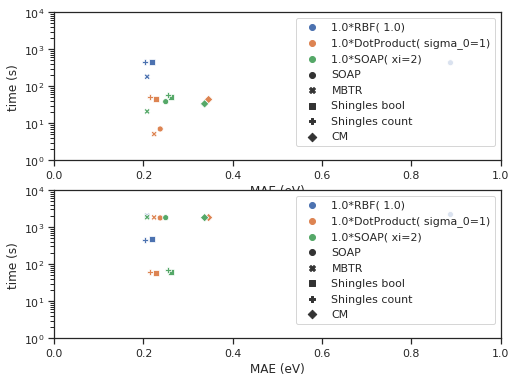

kernel  \
0               1.0*RBF( 1.0)   
1  1.0*DotProduct( sigma_0=1)   
2             1.0*SOAP( xi=2)   

                                                SOAP  \
0  [0.1, 0.001, 0.0001, 0.1, 0.1, 0.1, 0.1, 0.1, ...   
1  [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0...   
2  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   

                                                MBTR  \
0  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   
1  [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0...   
2  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   

                                       Shingles bool  \
0  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   
1  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   
2  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   

                                      Shingles count  \
0  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   
1  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   
2  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   

                                                  CM  
0  [1e-09, 1e-09, 1e-09, 1e-09, 1e-09, 1e-09, 1e-...  
1  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...  
2  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...

In [123]:
display_results(models, descriptors_mm, objective, output_results_path, geometry_type="MM", preprocessing=None)

## Normalization

kernel      SOAP      MBTR  Shingles bool  \
0               1.0*RBF( 1.0)  2.873382  0.208892       0.218163   
1  1.0*DotProduct( sigma_0=1)  0.239570  0.222855       0.227901   
2             1.0*SOAP( xi=2)  0.247786  0.208549       0.262537   

   Shingles count        CM  
0        0.202857  6.481331  
1        0.215675  0.349167  
2        0.254308  0.340522

kernel        SOAP        MBTR  Shingles bool  \
0               1.0*RBF( 1.0)  386.969074  173.202484     530.589472   
1  1.0*DotProduct( sigma_0=1)    7.790951    6.095645      40.217502   
2             1.0*SOAP( xi=2)   49.204008   28.249897      49.625776   

   Shingles count         CM  
0      458.881689  86.967219  
1       50.843664  54.230895  
2       46.109768  28.517973

kernel         SOAP         MBTR  Shingles bool  \
0               1.0*RBF( 1.0)  2148.087780  1999.745648     542.669637   
1  1.0*DotProduct( sigma_0=1)  1768.909657  1832.638809      52.297666   
2             1.0*SOAP( xi=2)  1810.322714  1854.793061      61.705940   

   Shingles count           CM  
0      470.822599  1855.075202  
1       62.784574  1822.338879  
2       58.050678  1796.625957

kernel        SOAP        MBTR  Shingles bool  \
0               1.0*RBF( 1.0)  392.839470  179.290961     530.629739   
1  1.0*DotProduct( sigma_0=1)   13.661347   12.184123      40.257769   
2             1.0*SOAP( xi=2)   55.074404   34.338374      49.666043   

   Shingles count         CM  
0      458.921492  92.860912  
1       50.883467  60.124589  
2       46.149571  34.411667

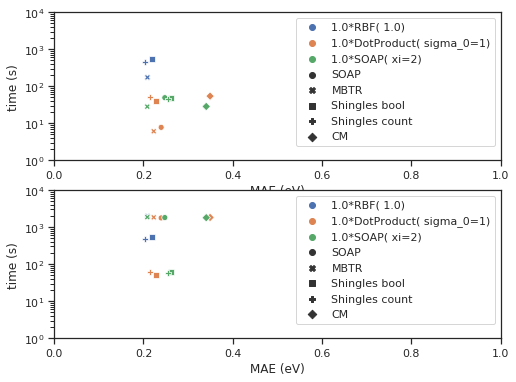

kernel  \
0               1.0*RBF( 1.0)   
1  1.0*DotProduct( sigma_0=1)   
2             1.0*SOAP( xi=2)   

                                                SOAP  \
0  [0.001, 0.0001, 0.0001, 0.001, 0.001, 0.001, 0...   
1  [0.1, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01...   
2  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   

                                                MBTR  \
0  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   
1  [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0...   
2  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   

                                       Shingles bool  \
0  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   
1  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   
2  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   

                                      Shingles count  \
0  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   
1  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   
2  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   

                                                  CM  
0  [1e-09, 1e-09, 1e-09, 1e-09, 1e-09, 1e-09, 1e-...  
1  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...  
2  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...

In [124]:
display_results(models, descriptors_mm, objective, output_results_path, geometry_type="MM", 
               preprocessing=Normalizer())

## Standard scaling

kernel      SOAP      MBTR  Shingles bool  \
0               1.0*RBF( 1.0)  3.486348  0.210281       0.218163   
1  1.0*DotProduct( sigma_0=1)  0.238573  0.224704       0.227901   
2             1.0*SOAP( xi=2)  0.248322  0.210008       0.262537   

   Shingles count        CM  
0        0.202857  6.478086  
1        0.215675  0.346818  
2        0.254308  0.339748

kernel        SOAP        MBTR  Shingles bool  \
0               1.0*RBF( 1.0)  355.382551  203.318032     617.328640   
1  1.0*DotProduct( sigma_0=1)    8.722354    7.454913      46.039539   
2             1.0*SOAP( xi=2)   39.646804   24.276049      53.261942   

   Shingles count         CM  
0      599.759137  70.574152  
1       53.060449  43.850868  
2       50.892878  28.160871

kernel         SOAP         MBTR  Shingles bool  \
0               1.0*RBF( 1.0)  2116.501257  2029.861196     629.408805   
1  1.0*DotProduct( sigma_0=1)  1769.841060  1833.998077      58.119704   
2             1.0*SOAP( xi=2)  1800.765510  1850.819213      65.342106   

   Shingles count           CM  
0      611.700046  1838.682136  
1       65.001358  1811.958852  
2       62.833788  1796.268854

kernel        SOAP        MBTR  Shingles bool  \
0               1.0*RBF( 1.0)  361.252947  209.406509     617.368908   
1  1.0*DotProduct( sigma_0=1)   14.592750   13.543390      46.079806   
2             1.0*SOAP( xi=2)   45.517200   30.364526      53.302209   

   Shingles count         CM  
0      599.798940  76.467846  
1       53.100252  49.744562  
2       50.932681  34.054564

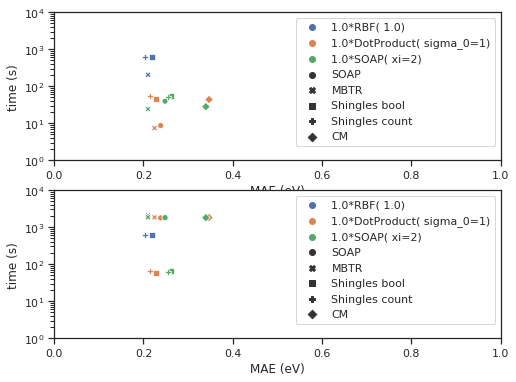

kernel  \
0               1.0*RBF( 1.0)   
1  1.0*DotProduct( sigma_0=1)   
2             1.0*SOAP( xi=2)   

                                                SOAP  \
0  [0.001, 0.001, 0.0001, 0.0001, 0.0001, 0.0001,...   
1  [0.1, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01...   
2  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   

                                                MBTR  \
0  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   
1  [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0...   
2  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   

                                       Shingles bool  \
0  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   
1  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   
2  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   

                                      Shingles count  \
0  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   
1  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   
2  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   

                                                  CM  
0  [1e-09, 1e-09, 1e-09, 1e-09, 1e-09, 1e-09, 1e-...  
1  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...  
2  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...

In [125]:
display_results(models, descriptors_mm, objective, output_results_path, geometry_type="MM", 
               preprocessing=StandardScaler())

# QM results

## No preprocessing

kernel      SOAP      MBTR        CM
0               1.0*RBF( 1.0)  3.461688  0.203990  6.514689
1  1.0*DotProduct( sigma_0=1)  0.240776  0.211624  0.362531
2             1.0*SOAP( xi=2)  0.259036  0.192879  0.360148

kernel        SOAP        MBTR         CM
0               1.0*RBF( 1.0)  490.518330  278.013584  81.858363
1  1.0*DotProduct( sigma_0=1)    7.916803    6.543425  80.461344
2             1.0*SOAP( xi=2)   90.341291    9.458128  53.041388

kernel        SOAP        MBTR         CM
0               1.0*RBF( 1.0)  495.357312  327.771454  85.758759
1  1.0*DotProduct( sigma_0=1)   12.755785   56.301295  84.361739
2             1.0*SOAP( xi=2)   95.180273   59.215997  56.941784

kernel        SOAP        MBTR         CM
0               1.0*RBF( 1.0)  490.534460  278.179444  81.871364
1  1.0*DotProduct( sigma_0=1)    7.932933    6.709285  80.474345
2             1.0*SOAP( xi=2)   90.357421    9.623987  53.054390

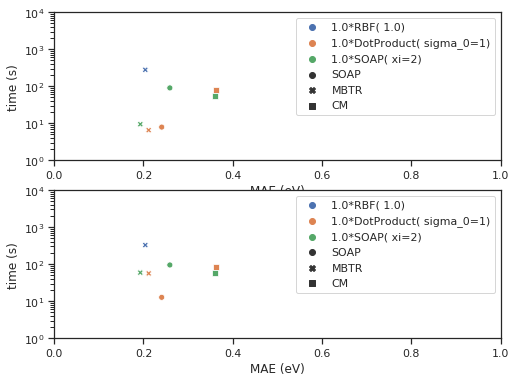

kernel  \
0               1.0*RBF( 1.0)   
1  1.0*DotProduct( sigma_0=1)   
2             1.0*SOAP( xi=2)   

                                                SOAP  \
0  [0.0001, 0.01, 0.01, 0.01, 0.0001, 0.01, 1e-05...   
1  [0.001, 0.001, 0.001, 0.01, 0.001, 0.001, 0.00...   
2  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   

                                                MBTR  \
0  [0.1, 0.01, 0.01, 0.1, 0.1, 0.01, 0.01, 0.1, 0...   
1  [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0...   
2  [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0...   

                                                  CM  
0  [1e-09, 1e-09, 1e-09, 1e-09, 1e-09, 1e-09, 1e-...  
1  [0.01, 0.01, 0.01, 0.01, 0.1, 0.01, 0.1, 0.01,...  
2  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...

In [126]:
display_results(models, descriptors_qm, objective, output_results_path, geometry_type="QM", preprocessing=None)